In [52]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seed for reproducibility
seed = 999
random.seed(seed)
torch.manual_seed(seed)

In [53]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [54]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [55]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [64]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv_stack = nn.Sequential(
            nn.LazyConv2d(out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            #nn.Dropout(0.25),

            nn.LazyConv2d(out_channels=8, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            nn.LazyConv2d(out_channels=4, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.LazyLinear(32),
            nn.ReLU(),

            nn.LazyLinear(10),
            nn.ReLU(),

            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.conv_stack(x)

    def reset_weights(self):
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()
        self.apply(weight_reset)

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

log_interval=100

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_counter_log_interval = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_counter_log_interval += len(y)
        if batch % log_interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)
            train_counter_last = train_counter[-1] if len(train_counter) > 0 else 0
            train_counter.append(train_counter_last + train_counter_log_interval)
            train_counter_log_interval = 0

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    test_losses.append(test_loss)


def decrease_learning_rate():
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * 0.95
        print(f"decreased learning rate to: {param_group['lr']:>0.7f}")

epochs = 6

train_losses = []
train_counter = []
test_losses = []

model.reset_weights()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    decrease_learning_rate()
print("Done!")

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.151752 

decreased learning rate to: 0.0009500
Epoch 2
-------------------------------
loss: 1.043990  [    0/60000]
loss: 1.147702  [ 6400/60000]
loss: 1.088284  [12800/60000]
loss: 1.048511  [19200/60000]
loss: 1.425193  [25600/60000]
loss: 1.193923  [32000/60000]
loss: 1.002983  [38400/60000]
loss: 1.187593  [44800/60000]
loss: 1.004013  [51200/60000]
loss: 0.942903  [57600/60000]
Test Error: 
 Accuracy: 65.2%, Avg loss: 0.906285 

decreased learning rate to: 0.0009025
Epoch 3
-------------------------------
loss: 0.972815  [    0/60000]
loss: 1.032144  [ 6400/60000]
loss: 0.846611  [12800/60000]
loss: 1.039886  [19200/60000]
loss: 1.184469  [25600/60000]
loss: 0.978431  [32000/60000]
loss: 0.951170  [38400/60000]
loss: 1.008570  [44800/60000]
loss: 0.930273  [51200/60000]
loss: 0.894730  [57600/60000]
Test Error: 
 Accuracy: 67.8%, Avg loss: 0.860141 

decreased learning rate to: 0.0008574
Epoch 4
-------------------------------
loss: 0.94

train counter: 150, last 864960


/var/folders/9x/xvb5bvms4s932mcb15g_y_fr0000gn/T/ipykernel_11419/3706497786.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


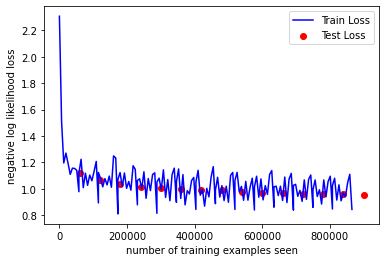

In [57]:
# training and test loss plot
print(f"train counter: {len(train_counter)}, last {train_counter[-1]}")
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter([(i+1)*len(train_dataloader.dataset) for i in range(epochs)], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()


In [58]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [59]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))
model

NeuralNetwork(
  (conv_stack): Sequential(
    (0): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): LazyConv2d(0, 8, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): LazyLinear(in_features=0, out_features=32, bias=True)
    (9): ReLU()
    (10): LazyLinear(in_features=0, out_features=10, bias=True)
    (11): ReLU()
    (12): LogSoftmax(dim=None)
  )
)

In [60]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.unsqueeze(0)
    pred = model(x)
    predicted = classes[pred[0].argmax(0)]
    actual = classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "Ankle boot", Actual: "Ankle boot"


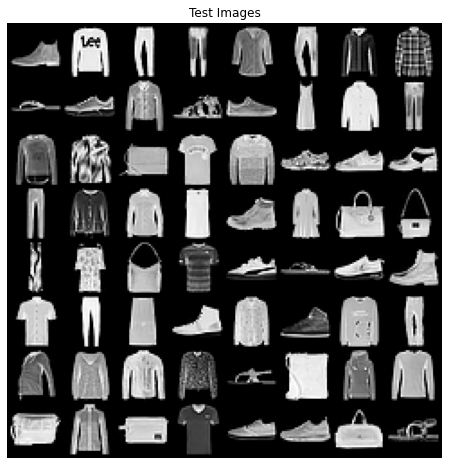

In [61]:
test_data_viz = next(iter(test_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(test_data_viz[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()